In [8]:
from splice.baseline import DCCA, Karakasis, DCCAE
import numpy as np

import matplotlib.pyplot as plt
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import math
import torch.nn.functional as F

from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE

In [2]:
data = np.load("../data/mnist/mnist_rotated_360.npz")

In [3]:
a_train = torch.Tensor(data["original"][:50000]).to(device).reshape(-1, 1, 28, 28)
b_train = torch.Tensor(data["rotated"][:50000]).to(device).reshape(-1, 1, 28, 28)   

a_validation = torch.Tensor(data["original"][50000:60000]).to(device).reshape(-1, 1, 28, 28)
b_validation = torch.Tensor(data["rotated"][50000:60000]).to(device).reshape(-1, 1, 28, 28)

a_test = torch.Tensor(data["original"][60000:]).to(device).reshape(-1, 1, 28, 28)
b_test = torch.Tensor(data["rotated"][60000:]).to(device).reshape(-1, 1, 28, 28)

labels = data["labels"]

### DCCAE

In [13]:
config =  {'_lambda': 0.1,'batch_size': 100, 'lr': 0.001, 'weight_decay': 0.001}

In [5]:
model = DCCAE(784, 784, 30, device, config["_lambda"], True)


In [14]:

# optimizer = torch.optim.AdamW(
#     model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
# )

# num_epochs = 100
batch_size = config["batch_size"]
# fail_count = 0
# success = False
# best_loss = np.inf
# best_params = None

# G = model.update_G(a_train, b_train, batch_size)

# for epoch in range(num_epochs):
#     print("EPOCH %d" % (epoch), end="\r")
#     for i in range(0, a_train.shape[0], batch_size):
#         a_batch = a_train[i : i + batch_size]
#         b_batch = b_train[i : i + batch_size]
#         g = G[i : i + batch_size]

#         x_a_hat, x_b_hat, z_a, z_b = model(a_batch, b_batch)
#         loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
#                             a_batch, b_batch, x_a_hat, x_b_hat, z_a, z_b, g
#                         )

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         del a_batch, b_batch, x_a_hat, x_b_hat, z_a, z_b

#     G = model.update_G(a_train, b_train, batch_size)

    
#     if epoch % 10 == 0:
#         x_a_hat, x_b_hat, z_val_a, z_val_b = model(
#                         a_validation, b_validation
#                     )

#         loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
#                         a_validation,
#                         b_validation,
#                         x_a_hat,
#                         x_b_hat,
#                         z_val_a,
#                         z_val_b,
#                         (z_val_a + z_val_b) / 2,
#                     )

#         if loss < best_loss:
#             best_loss = loss.item()
#             best_params = model.state_dict()

#         print("Validation Loss: %.4f" % (loss))

# model.load_state_dict(best_params)

z_train_a = []
z_train_b = []

for i in range(0, a_train.shape[0], batch_size):
    a_batch = a_train[i : i + batch_size]
    b_batch = b_train[i : i + batch_size]

    x_a_hat, x_b_hat, z_a, z_b = model(a_batch, b_batch)
    z_train_a.append(z_a)
    z_train_b.append(z_b)

z_train_a = torch.cat(z_train_a, dim=0).detach().cpu().numpy()
z_train_b = torch.cat(z_train_b, dim=0).detach().cpu().numpy()

x_a_hat, x_b_hat, z_a, z_b = model(a_validation, b_validation)

# a_acc = calculate_mnist_accuracy(
#     labels[50000:60000], z_train_a, z_val_a.detach().cpu().numpy()
# )
# b_acc = calculate_mnist_accuracy(
#     labels[50000:60000], z_train_b, z_val_b.detach().cpu().numpy()
# )

# # print("FINISHED")
# accuracy[rep] = max(a_acc, b_acc)
# print(accuracy[rep])
# success = True

In [8]:
torch.save(model.state_dict(), "../models/mnist/dccae_mnist360.pt")

In [15]:
model.load_state_dict(torch.load("../models/mnist/dccae_mnist360.pt"))

<All keys matched successfully>

In [16]:
_,_,z_test_a, z_test_b = model(a_test, b_test)

z_test_a = z_test_a.detach().cpu().numpy()
z_test_b = z_test_b.detach().cpu().numpy()

In [22]:
tsne = TSNE(n_components=2)
tsne_b = tsne.fit_transform(z_test_b)

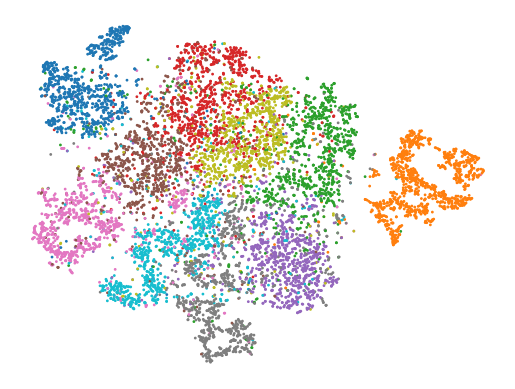

In [25]:
plt.scatter(tsne_b[:, 0], tsne_b[:, 1], c=labels[60000:], s=1, cmap="tab10");
plt.axis("off")
plt.savefig("../figures/arxiv_figures/DCCAE_mnist360_tsne.png", dpi=300)

In [21]:
svm = LinearSVC(max_iter=10000)
svm.fit(z_train_b, labels[:50000].astype(int))
svm.score(z_test_b, labels[60000:].astype(int))

0.781

In [13]:
corr = np.corrcoef(z_test_a.T, z_test_b.T)[30:60, :30]

In [18]:
trace = np.trace(corr)
trace/30

0.6196421210199533

In [22]:
x_a_hat, x_b_hat, z_a, z_b = model(a_test, b_test)
a_test = a_test.detach().cpu().numpy().squeeze()
b_test = b_test.detach().cpu().numpy().squeeze()
x_a_hat = x_a_hat.detach().cpu().numpy().squeeze()
x_b_hat = x_b_hat.detach().cpu().numpy().squeeze()

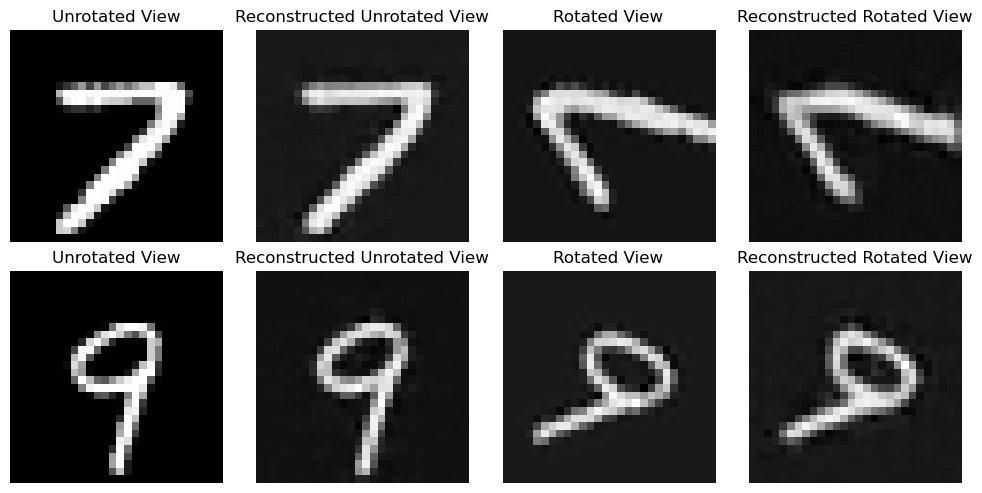

In [28]:
plt.figure(figsize=(10, 5))

ind1 = np.random.choice(10000)
ind2 = np.random.choice(10000)

plt.subplot(2, 4, 1)
plt.imshow(a_test[ind1], cmap="gray")
plt.title("Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 2)
plt.imshow(x_a_hat[ind1], cmap="gray")
plt.title("Reconstructed Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 3)
plt.imshow(b_test[ind1], cmap="gray")
plt.title("Rotated View")
plt.axis("off")

plt.subplot(2, 4, 4)
plt.imshow(x_b_hat[ind1], cmap="gray")
plt.title("Reconstructed Rotated View")
plt.axis("off")

plt.subplot(2, 4, 5)
plt.imshow(a_test[ind2], cmap="gray")
plt.title("Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 6)
plt.imshow(x_a_hat[ind2], cmap="gray")
plt.title("Reconstructed Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 7)
plt.imshow(b_test[ind2], cmap="gray")
plt.title("Rotated View")
plt.axis("off")

plt.subplot(2, 4, 8)
plt.imshow(x_b_hat[ind2], cmap="gray")
plt.title("Reconstructed Rotated View")
plt.axis("off")

plt.tight_layout()

plt.savefig("../figures/arxiv_figures/DCCAE_reconstructions.svg", transparent=True, dpi=300)

### Karakasis

In [31]:
# config = {'batch_size': 200, 'lr': 0.001, 'weight_decay': 0}
# {'batch_size': 100, 'lr': 0.0001, 'weight_decay': 0.001}
config =  {'_lambda': 0.1, 'batch_size': 100, 'lr': 0.0001, 'weight_decay': 0.001}

In [32]:
model = Karakasis(784, 784, 30, device, config["_lambda"], True)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
)

num_epochs = 100
batch_size = config["batch_size"]
fail_count = 0
success = False
best_loss = np.inf
best_params = None

G = model.update_G(a_train, b_train, batch_size)

for epoch in range(num_epochs):
    print("EPOCH %d" % (epoch), end="\r")
    for i in range(0, a_train.shape[0], batch_size):
        a_batch = a_train[i : i + batch_size]
        b_batch = b_train[i : i + batch_size]
        g = G[i : i + batch_size]

        x_a_hat, x_b_hat, z_a, z_b = model(a_batch, b_batch)
        loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
                            a_batch, b_batch, x_a_hat, x_b_hat, z_a, z_b, g
                        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del a_batch, b_batch, x_a_hat, x_b_hat, z_a, z_b

    G = model.update_G(a_train, b_train, batch_size)

    
    if epoch % 10 == 0:
        x_a_hat, x_b_hat, z_val_a, z_val_b = model(
                        a_validation, b_validation
                    )

        loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
                        a_validation,
                        b_validation,
                        x_a_hat,
                        x_b_hat,
                        z_val_a,
                        z_val_b,
                        (z_val_a + z_val_b) / 2,
                    )

        if loss < best_loss:
            best_loss = loss.item()
            best_params = model.state_dict()

        print("Validation Loss: %.4f" % (loss))

model.load_state_dict(best_params)

z_train_a = []
z_train_b = []

for i in range(0, a_train.shape[0], batch_size):
    a_batch = a_train[i : i + batch_size]
    b_batch = b_train[i : i + batch_size]

    x_a_hat, x_b_hat, z_a, z_b = model(a_batch, b_batch)
    z_train_a.append(z_a)
    z_train_b.append(z_b)

z_train_a = torch.cat(z_train_a, dim=0).detach().cpu().numpy()
z_train_b = torch.cat(z_train_b, dim=0).detach().cpu().numpy()

x_a_hat, x_b_hat, z_a, z_b = model(a_validation, b_validation)

# a_acc = calculate_mnist_accuracy(
#     labels[50000:60000], z_train_a, z_val_a.detach().cpu().numpy()
# )
# b_acc = calculate_mnist_accuracy(
#     labels[50000:60000], z_train_b, z_val_b.detach().cpu().numpy()
# )

# # print("FINISHED")
# accuracy[rep] = max(a_acc, b_acc)
# print(accuracy[rep])
# success = True

Validation Loss: 0.0065
Validation Loss: 0.0048
Validation Loss: 0.0046
Validation Loss: 0.0045
Validation Loss: 0.0046
Validation Loss: 0.0047
Validation Loss: 0.0048
Validation Loss: 0.0049
Validation Loss: 0.0050
Validation Loss: 0.0049


In [33]:
torch.save(model.state_dict(), "../models/mnist/karakasis_mnist360.pt")

In [48]:
_,_,z_test_a, z_test_b = model(a_test, b_test)

z_test_a = z_test_a.detach().cpu().numpy()
z_test_b = z_test_b.detach().cpu().numpy()

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [50]:
svm = LinearSVC(max_iter=10000)
svm.fit(z_train_a, labels[:50000].astype(int))
svm.score(z_test_a, labels[60000:].astype(int))

0.9346

### DCCA

In [12]:
config =  {'batch_size': 200, 'lr': 0.0001, 'weight_decay': 0.0001}

In [51]:
model = DCCA(784, 784, 30, device, True)

In [24]:
model = DCCA(784, 784, 30, device, True)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
)

num_epochs = 100
batch_size = config["batch_size"]
fail_count = 0
success = False
best_loss = np.inf
best_params = None

G = model.update_G(a_train, b_train, batch_size)

for epoch in range(num_epochs):
    print("EPOCH %d" % (epoch), end="\r")
    for i in range(0, a_train.shape[0], batch_size):
        a_batch = a_train[i : i + batch_size]
        b_batch = b_train[i : i + batch_size]
        g = G[i : i + batch_size]

        z_a, z_b = model(a_batch, b_batch)
        loss = model.loss(
                             z_a, z_b, g
                        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del a_batch, b_batch, z_a, z_b

    G = model.update_G(a_train, b_train, batch_size)

    
    if epoch % 10 == 0:
        z_val_a, z_val_b = model(
                        a_validation, b_validation
                    )

        loss = model.loss(
                        z_val_a,
                        z_val_b,
                        (z_val_a + z_val_b) / 2,
                    )

        if loss < best_loss:
            best_loss = loss.item()
            best_params = model.state_dict()

        print("Validation Loss: %.4f" % (loss))

model.load_state_dict(best_params)

z_train_a = []
z_train_b = []

for i in range(0, a_train.shape[0], batch_size):
    a_batch = a_train[i : i + batch_size]
    b_batch = b_train[i : i + batch_size]

    z_a, z_b = model(a_batch, b_batch)
    z_train_a.append(z_a)
    z_train_b.append(z_b)

z_train_a = torch.cat(z_train_a, dim=0).detach().cpu().numpy()
z_train_b = torch.cat(z_train_b, dim=0).detach().cpu().numpy()

# x_a_hat, x_b_hat, z_a, z_b = model(a_validation, b_validation)

# a_acc = calculate_mnist_accuracy(
#     labels[50000:60000], z_train_a, z_val_a.detach().cpu().numpy()
# )
# b_acc = calculate_mnist_accuracy(
#     labels[50000:60000], z_train_b, z_val_b.detach().cpu().numpy()
# )

# # print("FINISHED")
# accuracy[rep] = max(a_acc, b_acc)
# print(accuracy[rep])
# success = True

Validation Loss: 0.0003
Validation Loss: 0.0002
Validation Loss: 0.0001
Validation Loss: 0.0001
Validation Loss: 0.0001
Validation Loss: 0.0001
Validation Loss: 0.0001
Validation Loss: 0.0000
Validation Loss: 0.0000
Validation Loss: 0.0000


In [25]:
torch.save(model.state_dict(), "../models/mnist/dcca_mnist360.pt")

In [53]:
z_train_a = []
z_train_b = []

model.load_state_dict(torch.load("../models/mnist/dcca_mnist360.pt"))

for i in range(0, a_train.shape[0], batch_size):
    a_batch = a_train[i : i + batch_size]
    b_batch = b_train[i : i + batch_size]

    z_a, z_b = model(a_batch, b_batch)
    z_train_a.append(z_a)
    z_train_b.append(z_b)

z_train_a = torch.cat(z_train_a, dim=0).detach().cpu().numpy()
z_train_b = torch.cat(z_train_b, dim=0).detach().cpu().numpy()

In [58]:
z_test_a, z_test_b = model(a_test, b_test)

z_test_a = z_test_a.detach().cpu().numpy()
z_test_b = z_test_b.detach().cpu().numpy()

In [60]:
svm = LinearSVC(max_iter=10000)
svm.fit(z_train_b, labels[:50000].astype(int))
svm.score(z_test_b, labels[60000:].astype(int))

0.907

In [38]:
x_a_hat, x_b_hat, z_a, z_b = model(a_test, b_test)
a_test = a_test.detach().cpu().numpy().squeeze()
b_test = b_test.detach().cpu().numpy().squeeze()
x_a_hat = x_a_hat.detach().cpu().numpy().squeeze()
x_b_hat = x_b_hat.detach().cpu().numpy().squeeze()

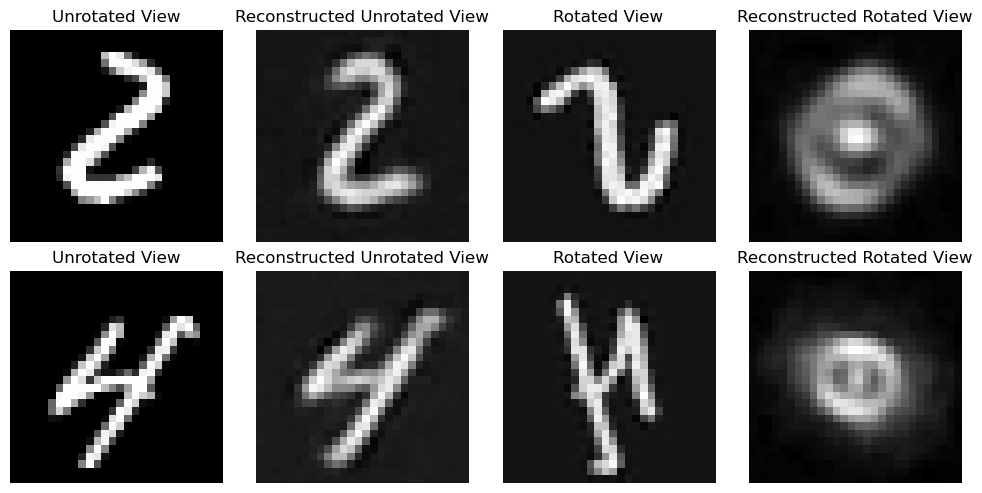

In [42]:
plt.figure(figsize=(10, 5))

ind1 = np.random.choice(10000)
ind2 = np.random.choice(10000)

plt.subplot(2, 4, 1)
plt.imshow(a_test[ind1], cmap="gray")
plt.title("Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 2)
plt.imshow(x_a_hat[ind1], cmap="gray")
plt.title("Reconstructed Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 3)
plt.imshow(b_test[ind1], cmap="gray")
plt.title("Rotated View")
plt.axis("off")

plt.subplot(2, 4, 4)
plt.imshow(x_b_hat[ind1], cmap="gray")
plt.title("Reconstructed Rotated View")
plt.axis("off")

plt.subplot(2, 4, 5)
plt.imshow(a_test[ind2], cmap="gray")
plt.title("Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 6)
plt.imshow(x_a_hat[ind2], cmap="gray")
plt.title("Reconstructed Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 7)
plt.imshow(b_test[ind2], cmap="gray")
plt.title("Rotated View")
plt.axis("off")

plt.subplot(2, 4, 8)
plt.imshow(x_b_hat[ind2], cmap="gray")
plt.title("Reconstructed Rotated View")
plt.axis("off")

plt.tight_layout()

plt.savefig("../figures/arxiv_figures/Karakasis_reconstructions.svg", transparent=True, dpi=300)

In [48]:
model.load_state_dict(best_params)
x_a_hat, x_b_hat, z_a2b, z_b2a, z_b = model(a_validation, b_validation)

In [23]:
z_b = z_b.detach().cpu().numpy()

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
z_val_a = tsne.fit_transform(z_test_a)
z_val_b = tsne.fit_transform(z_test_b)

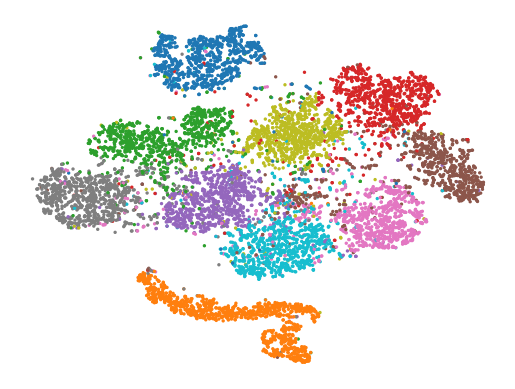

In [66]:
plt.scatter(z_val_b[:, 0], z_val_b[:, 1], c=labels[60000:], cmap="tab10", s=2)
plt.axis("off"); plt.savefig("../figures/arxiv_figures/DCCA_mnist360_tsne.svg", transparent=True, dpi=300)

In [50]:
calculate_mnist_accuracy(labels[50000:60000], z_b2a.detach().cpu().numpy(), z_b2a.detach().cpu().numpy())

c:\Users\Harris_Lab\miniconda3\envs\splice\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.6851